In [1]:
import pandas as pd
import geopandas as gpd
import os
import ast
import numpy as np
import math
import matplotlib as plt
from shapely.geometry import Point

pd.set_option('display.max_columns', None)
os.chdir(r"C:\Users\LMENENDEZ\GitHub\MultiModX")
print(os.getcwd())

C:\Users\LMENENDEZ\GitHub\MultiModX


In [2]:
%load_ext autoreload

In [3]:
%autoreload
from script.trips_format import *

## 1. Download AW data

In [4]:
aw_paths_w_costs_airports=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain+abroad\CS11\aw\aw_paths_costs.csv")

aw_paths_w_costs_airports has information about the city of origin, the city of destination, the air path taken and the costs of this path. The path is a sequence of airports.

In [5]:
def format_aw_paths(paths):
    paths=paths.drop(["Unnamed: 0"],axis=1) #drops additional column
    paths["cost"]=round(paths["Avg. Total Fare(USD)"]*0.9,2) #gets prices in euro

    paths=paths.dropna(how="any") #drop nan values
    
    # co2 emissions should be added at some point
    return paths


In [6]:
aw_paths_w_costs_airports=format_aw_paths(aw_paths_w_costs_airports)

In [7]:
aw_paths_w_costs_airports.head()

,origin,destination,origin_city,destination_city,path,Passengers,origin_airport,destination_airport,Avg. Total Fare(USD),Distance (km),cost
0,BIKF,GCLP,BIKF,GCLP,"['BIKF', 'GCLP']",24.100000,BIKF,GCLP,149.34,4041.0,134.41
1,BIKF,GCTS,BIKF,GCTS,"['BIKF', 'GCTS']",74.633333,BIKF,GCTS,148.93,4020.0,134.04
2,BIKF,LEAL,BIKF,LEAL,"['BIKF', 'LEAL']",123.818333,BIKF,LEAL,161.65,3207.0,145.49
3,BIKF,LEBL,BIKF,LEBL,"['BIKF', 'LEBL']",136.487000,BIKF,LEBL,198.16,2981.0,178.34
4,BIKF,LEMD,BIKF,LEMD,"['BIKF', 'LEMD']",100.200333,BIKF,LEMD,216.87,2892.0,195.18


In [8]:
def create_aw_paths_cities(paths):
    #creates a new columns
    paths["list_of_nodes"]=paths["path"].apply(lambda x: ast.literal_eval(x))

    #creates two masks
    mask_origin=paths["origin_city"]!=paths["list_of_nodes"].str[0]
    mask_destination=paths["destination_city"]!=paths["list_of_nodes"].str[-1]

    #changes first node to origin city
    paths.loc[mask_origin,"list_of_nodes"]=paths[mask_origin].apply(
        lambda row: [row["origin_city"]]+row["list_of_nodes"][1:],axis=1
    )

    #changes last node to destination city
    paths.loc[mask_destination,"list_of_nodes"]=paths[mask_destination].apply(
        lambda row: row["list_of_nodes"][:-1]+[row["destination_city"]],axis=1
    )
    # update the column path
    paths["path"]=paths["list_of_nodes"].astype(str)

    #drop the list_of_nodes columns
    paths=paths.drop(["list_of_nodes"],axis=1)

    #groupby for each path and take average of the rest of 
    columns=list(paths.columns)
    columns_grouped_by=[column for column in columns if column not in ["Avg. Total Fare(USD)","Distance (km)","cost", "Passengers"]]
    total_before = paths[paths.notna()]["Passengers"].sum()

    paths["Passengers"]=paths["Passengers"].round(6)
    paths=paths.groupby(columns_grouped_by).agg({
        "Avg. Total Fare(USD)":"mean",
        "Distance (km)": "mean",
        "cost":"mean",
        "Passengers": "sum"
    }).reset_index()
    
    total_after = paths.groupby(columns_grouped_by)["Passengers"].sum().sum()
    print(f"Sum before groupby: {total_before}, after: {total_after}")

    paths=paths.groupby(["origin_city","destination_city","path"]).agg(
       cost=("cost", lambda x: np.average(x,weights=paths.loc[x.index,"Passengers"])),
       distance=("Distance (km)", lambda x: np.average(x,weights=paths.loc[x.index,"Passengers"])),
        Passengers=("Passengers","sum")
    ).reset_index()
    total_final=paths["Passengers"].sum()
    print(f"the total final is {total_final}")

    return paths


In [9]:
aw_paths_w_costs_cities=create_aw_paths_cities(aw_paths_w_costs_airports)

Sum before groupby: 528112.7383333333, after: 528112.738316
the total final is 528112.738316


In [10]:
aw_paths_w_costs_cities.sample(4)

,origin_city,destination_city,path,cost,distance,Passengers
3130,VENICE,LEAL,"['VENICE', 'LEAL']",90.86000,1334.000000,19.545333
1128,KFLL,LEBL,"['KFLL', 'LEBL']",286.76000,7514.000000,74.635333
2108,LEPA,FRANKFURT,"['LEPA', 'FRANKFURT']",82.41684,1246.707247,2199.340666
1526,LEBL,UKLL,"['LEBL', 'UKLL']",152.33000,1931.000000,27.712000


## 2. Download the coefficients

In [11]:
coeff_outgoing=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain+abroad\CS11\coefficients\coefficients_outgoing_trips_from_spain_v0.5.csv")

In [12]:
coeff_incoming=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain+abroad\CS11\coefficients\coefficients_incoming_trips_to_spain_v0.5.csv")

In [13]:
coeff_incoming.columns

Index(['last_airport', 'destination', 'destination_name',
       'node_sequence_ground', 'trips', 'total_trips', 'coeff'],
      dtype='object')

In [14]:
aw_paths_w_costs_small=aw_paths_w_costs_cities[(aw_paths_w_costs_cities["origin_city"]=="LEZL")|(aw_paths_w_costs_cities["destination_city"]=="LEZL")]

In [15]:
# Group by 'last_airport' and 'node_sequence_spain', then count unique 'destination' values
conflicts = (
    coeff_incoming.groupby(['last_airport', 'node_sequence_ground'])
    ['destination'].nunique()  # Count unique destinations per group
    .gt(1)                    # Check if count > 1 (conflict exists)
    .reset_index(name='has_conflict')
)

# Get the full rows where conflicts occur
conflicting_rows = coeff_incoming.merge(
    conflicts[conflicts['has_conflict']],
    on=['last_airport', 'node_sequence_ground']
)


In [16]:
conflicting_rows[conflicting_rows["node_sequence_ground"]!="egress"]

,last_airport,destination,destination_name,node_sequence_ground,trips,total_trips,coeff,has_conflict
26,LEBB,ES211,Álava,"['007113200', '007111200']",0.321482,6183.029558,0.000052,True
30,LEBB,ES220,Navarra,"['007113200', '007111200']",0.049486,6183.029558,0.000008,True
32,LEBB,ES230,La Rioja,"['007113200', '007111200']",1.355357,6183.029558,0.000219,True
36,LEBB,ES412,Burgos,"['007113200', '007111200']",8.218265,6183.029558,0.001329,True
71,LEBL,ES514,Tarragona,"['007171801', '007165402']",238.390015,73626.275263,0.003238,True
73,LEBL,ES521,Alicante / Alacant,"['007171801', '007165402']",1.184994,73626.275263,0.000016,True
75,LEBL,ES522,Castellón / Castelló,"['007171801', '007165402']",1.458899,73626.275263,0.000020,True
108,LEGE,ES511,Barcelona,"['007179300', '007171801']",467.269906,10800.651475,0.043263,True
111,LEGE,ES513,Lleida,"['007179300', '007171801']",0.953331,10800.651475,0.000088,True
113,LEGE,ES514,Tarragona,"['007171801', '007165402']",13.061762,10800.651475,0.001209,True


Create a dictionary with nuts_to_name to use later

In [17]:
name_to_nuts=dict(zip(coeff_incoming["destination_name"],coeff_incoming["destination"]))

In [18]:
origin_pairs=set(zip(coeff_outgoing["origin_name"],coeff_outgoing["origin"]))

In [19]:
dict_pairs=set(name_to_nuts.items())

In [20]:
missing_pairs=origin_pairs-dict_pairs

In [21]:
missing_pairs

set()

## 3. Assign ground paths

In [22]:
def generate_probabilities_incoming(selected_paths: pd.DataFrame):
    """given a set a options, selects and normalises the probabilities"""
    paths_options=selected_paths[["node_sequence_ground","destination","destination_name"]].values
    probs= selected_paths["coeff"].values
    probs= probs/probs.sum() #normalises probabilities

    paths_options_tuples = [tuple(row) for row in paths_options]
    return paths_options_tuples, probs

In [23]:
def generate_probabilities_outgoing(selected_paths: pd.DataFrame):
    """given a set a options, selects and normalises the probabilities"""
    paths_options=selected_paths[["node_sequence_ground","origin","origin_name"]].values
    probs= selected_paths["coeff"].values
    probs= probs/probs.sum() #normalises probabilities

    paths_options_tuples = [tuple(row) for row in paths_options]
    return paths_options_tuples, probs

In [24]:
def generate_ground_path_incoming(selected_trips: pd.DataFrame,paths_options,probs):
    """given selected trips, generates the international path using the probabilities of path_options_probs"""
    new_rows=[]
    for _, row in selected_trips.iterrows():
        trips_raw=row["Passengers"]
        trips_count = math.ceil(trips_raw) if trips_raw < 1 else round(trips_raw) # Number of trips to generate

        chosen_indices = np.random.choice(
            len(paths_options), 
            size=trips_count,  # Generate all needed samples in one call
            p=probs
        )

      # Get paths corresponding to chosen indices
        chosen_paths = [paths_options[i] for i in chosen_indices]
        
        # Count occurrences of each path
        path_counts = {}
        for path in chosen_paths:
            path_tuple = tuple(path)  # Ensure hashability
            path_counts[path_tuple] = path_counts.get(path_tuple, 0) + 1
        
        # Build output rows
        for path, count in path_counts.items():
            new_row = row.to_dict()
            new_row.update({
                "node_sequence_ground": path[0],
                "destination": path[1],
                "destination_name": path[2],
                "trips": float(count)
            })
            new_rows.append(new_row)

    return new_rows

In [25]:
def generate_ground_path_outgoing(selected_trips: pd.DataFrame,paths_options,probs):
    """given selected trips, generates the international path using the probabilities of path_options_probs"""
    new_rows=[]
    for _, row in selected_trips.iterrows():
        trips_raw=row["Passengers"]
        trips_count = math.ceil(trips_raw) if trips_raw < 1 else round(trips_raw) # Number of trips to generate

        chosen_indices = np.random.choice(
            len(paths_options), 
            size=trips_count,  # Generate all needed samples in one call
            p=probs
        )

      # Get paths corresponding to chosen indices
        chosen_paths = [paths_options[i] for i in chosen_indices]
        
        # Count occurrences of each path
        path_counts = {}
        for path in chosen_paths:
            path_tuple = tuple(path)  # Ensure hashability
            path_counts[path_tuple] = path_counts.get(path_tuple, 0) + 1
        
        # Build output rows
        for path, count in path_counts.items():
            new_row = row.to_dict()
            new_row.update({
                "node_sequence_ground": path[0],
                "origin": path[1],
                "origin_name": path[2],
                "trips": float(count)
            })
            new_rows.append(new_row)

    return new_rows

In [26]:
coeff_incoming.columns.values

array(['last_airport', 'destination', 'destination_name',
       'node_sequence_ground', 'trips', 'total_trips', 'coeff'],
      dtype=object)

In [27]:
aw_paths_w_costs_cities

,origin_city,destination_city,path,cost,distance,Passengers
0,BEIJING,LEBL,"['BEIJING', 'LEBL']",409.75,9409.875000,54.705667
1,BEIJING,LEMD,"['BEIJING', 'LEMD']",439.42,9972.000000,75.585333
2,BELFAST,GCFV,"['BELFAST', 'GCFV']",115.82,2977.000000,45.872000
3,BELFAST,GCLP,"['BELFAST', 'GCLP']",117.32,3063.000000,51.606333
4,BELFAST,GCRR,"['BELFAST', 'GCRR']",121.82,2921.000000,107.319000
...,...,...,...,...,...,...
3153,ZGSZ,LEMD,"['ZGSZ', 'LEMD']",387.52,10472.000000,40.022333
3154,ZLXY,LEMD,"['ZLXY', 'LEMD']",369.69,9185.000000,25.571333
3155,ZSPD,LEBL,"['ZSPD', 'LEBL']",484.59,10308.444444,97.635000
3156,ZSPD,LEMD,"['ZSPD', 'LEMD']",417.20,10962.166667,170.500667


In [28]:
coeff_incoming

,last_airport,destination,destination_name,node_sequence_ground,trips,total_trips,coeff
0,LEAL,ES114,Pontevedra,"['007160911', '007122100']",8.034224,36988.543274,0.000217
1,LEAL,ES120,Asturias,egress,1.766597,36988.543274,0.000048
2,LEAL,ES241,Huesca,egress,2.742340,36988.543274,0.000074
3,LEAL,ES300,Madrid,"['007160911', '007117000']",5.019661,36988.543274,0.000136
4,LEAL,ES300,Madrid,egress,9.195157,36988.543274,0.000249
...,...,...,...,...,...,...,...
491,LEZL,ES616,Jaén,egress,3.583077,5663.341747,0.000633
492,LEZL,ES617,Málaga,"['007151003', '007154413']",1.668329,5663.341747,0.000295
493,LEZL,ES617,Málaga,egress,5.258203,5663.341747,0.000928
494,LEZL,ES618,Sevilla,egress,4987.149433,5663.341747,0.880602


In [29]:
def assign_ground_path(trips_aw: pd.DataFrame, coeff_outgoing: pd.DataFrame, coeff_incoming: pd.DataFrame):
        #create two empty dataframe with the relevant columns
        columns_aw=list(trips_aw.columns.values)
        columns_in=[column for column in coeff_incoming.columns if column not in ["total_trips","coeff"]]
        columns_out=[column for column in coeff_incoming.columns if column not in ["total_trips","coeff"] ]
        columns_selected=list(set(columns_aw+columns_in+columns_out))
        trips_incoming_with_complete_path=pd.DataFrame(columns=columns_selected)
        trips_outgoing_with_complete_path=pd.DataFrame(columns=columns_selected)
        
        #create lists of spanish origin and destination airports
        destination_airports=list(trips_aw["destination_city"])
        spanish_destination_airports=set([airport for airport in destination_airports if airport.startswith("LE") or airport.startswith("GC")])
        origin_airports=list(trips_aw["origin_city"])
        spanish_origin_airports=set([airport for airport in origin_airports if airport.startswith("LE") or airport.startswith("GC")])

        # first iterate over destination airports (incoming trips)
        for airport in spanish_destination_airports:
                selected_trips=trips_aw[trips_aw["destination_city"]==airport]
                selected_ground_paths=coeff_incoming[coeff_incoming["last_airport"]==airport]
                if not selected_ground_paths.empty:
                        ground_paths_options, probs=generate_probabilities_incoming(selected_ground_paths)
                        new_rows=generate_ground_path_incoming(selected_trips,ground_paths_options,probs)
                        #print(ground_paths_options)
                        #print(probs)
                        new_df=pd.DataFrame(new_rows)
                        columns= list(new_df.columns.values)
                        columns.remove("trips")
                        #print(new_rows)
                        new_df=new_df.groupby(columns).sum().reset_index()
                        trips_incoming_with_complete_path=pd.concat([trips_incoming_with_complete_path,new_df])

        # drop irrelevant columns for trips_incoming_with_complete_path
        trips_incoming_with_complete_path=trips_incoming_with_complete_path.drop(columns=["destination",
                                                                "last_airport",
                                                                "destination_city"
                                                                ])
        
        # rename columns for trips_incoming_with_complete_path for clarity
        trips_incoming_with_complete_path=trips_incoming_with_complete_path.rename(columns={"origin_city": "origin",
                                                                          "destination_name":"destination",
                                                                          "distance":"distance_air",
                                                                          "cost":"cost_air",
                                                                          "path":"node_sequence_air",
                                                                          "Passengers":"trips_air"
                                                                          })
        # second iterate over origin airports (outgoing trips)
        for airport in spanish_origin_airports:
                selected_trips=trips_aw[trips_aw["origin_city"]==airport]
                selected_ground_paths=coeff_outgoing[coeff_outgoing["first_airport"]==airport]
                if not selected_ground_paths.empty:
                        ground_paths_options, probs=generate_probabilities_outgoing(selected_ground_paths)
                        new_rows=generate_ground_path_outgoing(selected_trips,ground_paths_options,probs)
                        #print(ground_paths_options)
                        #print(probs)
                        new_df=pd.DataFrame(new_rows)
                        columns= list(new_df.columns.values)
                        columns.remove("trips")
                        #print(new_rows)
                        new_df=new_df.groupby(columns).sum().reset_index()
                        trips_outgoing_with_complete_path=pd.concat([trips_outgoing_with_complete_path,new_df])

        trips_outgoing_with_complete_path=trips_outgoing_with_complete_path.drop(columns=["destination",
                                                        "origin",
                                                        "last_airport",
                                                        "origin_city",
                                                        "destination_name"
                                                        ])
        
        trips_outgoing_with_complete_path=trips_outgoing_with_complete_path.rename(columns={"destination_city": "destination",
                                                                        "origin_name":"origin",
                                                                        "distance":"distance_air",
                                                                        "cost":"cost_air",
                                                                        "path":"node_sequence_air",
                                                                        "Passengers":"trips_air"
                                                                        })

        trips_with_complete_path=pd.concat([trips_incoming_with_complete_path,trips_outgoing_with_complete_path],ignore_index=True)

        #re-order the columns
        trips_with_complete_path=trips_with_complete_path[["origin",
                                                                "destination",
                                                                "node_sequence_ground",
                                                                "node_sequence_air",
                                                                "trips",
                                                                "trips_air",
                                                                "cost_air",
                                                                "distance_air"
                                                                ]]
        return trips_with_complete_path 


In [30]:
thing=list(coeff_incoming.columns.values)

In [31]:
trips_complete_small=assign_ground_path(aw_paths_w_costs_small,coeff_outgoing,coeff_incoming)

C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_7056\3393236283.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trips_incoming_with_complete_path=pd.concat([trips_incoming_with_complete_path,new_df])
C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_7056\3393236283.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trips_outgoing_with_complete_path=pd.concat([trips_outgoing_with_complete_path,new_df])


## 4. Analysis of the assignation

In [32]:
trips_complete_small

,origin,destination,node_sequence_ground,node_sequence_air,trips,trips_air,cost_air,distance_air
0,BERLIN,Cádiz,"['007151003', '007151406']","['BERLIN', 'LEZL']",3.0,111.039333,103.0100,2243.000000
1,BERLIN,A Coruña,egress,"['BERLIN', 'LEZL']",1.0,111.039333,103.0100,2243.000000
2,BERLIN,Eivissa i Formentera,egress,"['BERLIN', 'LEZL']",1.0,111.039333,103.0100,2243.000000
3,BERLIN,Cádiz,egress,"['BERLIN', 'LEZL']",8.0,111.039333,103.0100,2243.000000
4,BERLIN,Sevilla,egress,"['BERLIN', 'LEZL']",98.0,111.039333,103.0100,2243.000000
...,...,...,...,...,...,...,...,...
498,Cádiz,VENICE,"['007151406', '007151003']","['LEZL', 'VENICE']",1.0,142.875000,43.7158,1758.819668
499,Cádiz,VENICE,access,"['LEZL', 'VENICE']",8.0,142.875000,43.7158,1758.819668
500,Córdoba,VENICE,access,"['LEZL', 'VENICE']",1.0,142.875000,43.7158,1758.819668
501,Huelva,VENICE,access,"['LEZL', 'VENICE']",4.0,142.875000,43.7158,1758.819668


In [33]:
trips_complete_small[trips_complete_small["trips_air"]==111.039333]

,origin,destination,node_sequence_ground,node_sequence_air,trips,trips_air,cost_air,distance_air
0,BERLIN,Cádiz,"['007151003', '007151406']","['BERLIN', 'LEZL']",3.0,111.039333,103.01,2243.0
1,BERLIN,A Coruña,egress,"['BERLIN', 'LEZL']",1.0,111.039333,103.01,2243.0
2,BERLIN,Eivissa i Formentera,egress,"['BERLIN', 'LEZL']",1.0,111.039333,103.01,2243.0
3,BERLIN,Cádiz,egress,"['BERLIN', 'LEZL']",8.0,111.039333,103.01,2243.0
4,BERLIN,Sevilla,egress,"['BERLIN', 'LEZL']",98.0,111.039333,103.01,2243.0


In [34]:
trips_complete_small[trips_complete_small["trips_air"]==142.875000]

,origin,destination,node_sequence_ground,node_sequence_air,trips,trips_air,cost_air,distance_air
498,Cádiz,VENICE,"['007151406', '007151003']","['LEZL', 'VENICE']",1.0,142.875,43.7158,1758.819668
499,Cádiz,VENICE,access,"['LEZL', 'VENICE']",8.0,142.875,43.7158,1758.819668
500,Córdoba,VENICE,access,"['LEZL', 'VENICE']",1.0,142.875,43.7158,1758.819668
501,Huelva,VENICE,access,"['LEZL', 'VENICE']",4.0,142.875,43.7158,1758.819668
502,Sevilla,VENICE,access,"['LEZL', 'VENICE']",129.0,142.875,43.7158,1758.819668


In [35]:
trips_complete=assign_ground_path(trips_aw=aw_paths_w_costs_cities,
                                  coeff_incoming=coeff_incoming,
                                  coeff_outgoing=coeff_outgoing
                                  )

C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_7056\3393236283.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trips_incoming_with_complete_path=pd.concat([trips_incoming_with_complete_path,new_df])
C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_7056\3393236283.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trips_outgoing_with_complete_path=pd.concat([trips_outgoing_with_complete_path,new_df])


In [36]:
trips_complete.sample(4)

,origin,destination,node_sequence_ground,node_sequence_air,trips,trips_air,cost_air,distance_air
59,VENICE,Navarra,"['007104040', '007180100']","['VENICE', 'LEZG']",1.0,40.312667,95.510000,1159.000000
1993,LFMN,Segovia,egress,"['LFMN', 'LEMD']",2.0,174.237000,173.740000,958.000000
4245,LONDON,Jaén,"['007151003', '007150300']","['LONDON', 'LEZL']",1.0,560.193666,105.289737,1637.248198
2782,MMMX,Almería,egress,"['MMMX', 'LEMD']",2.0,625.806333,900.040000,9067.000000


In [37]:
print(trips_complete.shape[0])
print(trips_complete[trips_complete.notna().all(axis=1)].shape[0])
print(trips_complete.dropna().shape[0])
print(trips_complete[trips_complete["trips"]==1].shape[0])
print(trips_complete[trips_complete["trips"]==2].shape[0])
print(trips_complete[trips_complete["trips"]==3].shape[0])

12181
12181
12181
5334
1729
822


many trips have only one person. Is it a problem?

In [38]:
trips_complete=trips_complete.sort_values(["origin","destination","trips"],ascending=[True,True,False])

In [39]:
trips_complete["option_number"]=trips_complete.groupby(["origin","destination"]).cumcount() +1

In [40]:
trips_complete["option_number"].describe()

count    12181.000000
mean         1.617437
std          1.093392
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         12.000000
Name: option_number, dtype: float64

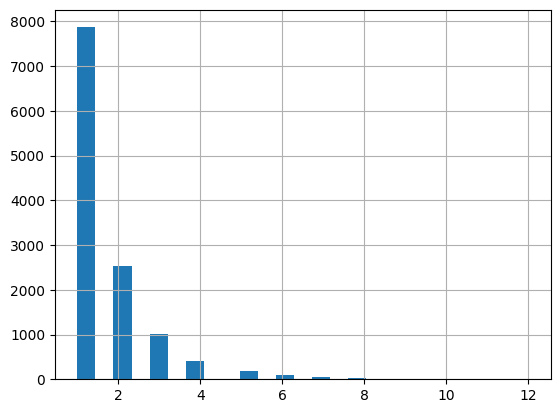

In [41]:
hist=trips_complete["option_number"].hist(bins=25)

Most of the OD pair have only one trip, but this is okay, I will use only the ones that have more than 1 to calibrate the Logit model

In [42]:
trips_london=trips_complete[(trips_complete["origin"]=="LONDON")&(trips_complete["destination"]=="Málaga")]

In [43]:
trips_london

,origin,destination,node_sequence_ground,node_sequence_air,trips,trips_air,cost_air,distance_air,option_number
4842,LONDON,Málaga,egress,"['LONDON', 'LEMG']",3250.0,3445.605667,104.512622,1687.569051,1
4978,LONDON,Málaga,"['007105000', '007154413']","['LONDON', 'LEGR']",16.0,103.284666,111.920307,1593.347312,2
5988,LONDON,Málaga,egress,"['LONDON', 'LEBL']",11.0,4509.112333,121.150000,1139.832083,3
2386,LONDON,Málaga,egress,"['LONDON', 'LEMD']",8.0,3432.608001,134.631769,1247.621351,4
585,LONDON,Málaga,egress,"['LONDON', 'LEAL']",7.0,2803.311000,96.429028,1471.340343,5
4982,LONDON,Málaga,egress,"['LONDON', 'LEGR']",4.0,103.284666,111.920307,1593.347312,6
1050,LONDON,Málaga,egress,"['LONDON', 'LEGE']",2.0,320.675333,87.767551,1120.538013,7
4255,LONDON,Málaga,egress,"['LONDON', 'LEZL']",2.0,560.193666,105.289737,1637.248198,8
3928,LONDON,Málaga,egress,"['LONDON', 'LEVC']",1.0,885.103666,102.749886,1331.803608,9


## 5. Assign costs

In [44]:
trips_complete[~trips_complete["node_sequence_ground"].isin(["egress","access"])].shape[0]

1177

We have potentially 1123 non "egress" "access" to which I have to assign costs. I also have to assign costs in time to the egress/access phases of trips with trivial ground path

In [45]:
trips_complete[trips_complete["node_sequence_air"].apply(lambda x: len(ast.literal_eval(x))>=3)]

,origin,destination,node_sequence_ground,node_sequence_air,trips,trips_air,cost_air,distance_air,option_number
10200,A Coruña,BRUSSELS,access,"['LEST', 'LEMD', 'BRUSSELS']",11.0,12.087667,134.69,1559.500000,2
10202,A Coruña,DUESSELDORF,access,"['LEST', 'LEMD', 'DUESSELDORF']",21.0,21.724667,152.02,1925.000000,1
6961,A Coruña,DUESSELDORF,access,"['LEAS', 'LEMD', 'DUESSELDORF']",1.0,12.743000,174.24,1839.000000,2
10204,A Coruña,EDDH,access,"['LEST', 'LEMD', 'EDDH']",10.0,10.389333,123.35,2266.000000,1
10206,A Coruña,EDDM,access,"['LEST', 'LEMD', 'EDDM']",10.0,12.387667,213.24,1830.000000,2
...,...,...,...,...,...,...,...,...,...
12043,Álava,LPPR,access,"['LEBB', 'LEMD', 'LPPR']",1.0,10.867000,82.39,761.666667,3
12080,Álava,MMMX,access,"['LEBB', 'LEMD', 'MMMX']",1.0,15.863667,833.95,9386.000000,2
12084,Álava,NEW YORK,access,"['LEBB', 'LEMD', 'NEW YORK']",4.0,22.504333,561.78,6080.000000,1
12102,Álava,SKBO,access,"['LEBB', 'LEMD', 'SKBO']",2.0,11.768333,527.76,8349.000000,1


Some trips make scale in air. I would need accurate information for times for this, but I can make that up for this first calibration

In [46]:
trips_complete.shape[0]

12181

In [47]:
trips_complete.dropna().shape[0]

12181

### 5.1. Assign time of flight

(this will not be necessary once it is done by the pipeline. It is a preliminary rough time assignation)

In [48]:
avg_speed= 900 #km/h
def time_of_flight(distance):
    tof=round(distance/avg_speed*60) #multiplied by 60 to have the time in minutes
    return tof

In [49]:
def assign_time_cost(trips):
    
    trips["total_time_air"]=trips["distance_air"].apply(time_of_flight) #calculate time of flight based on speed
    # adds additional 120 minutes when there is a plane transfer
    trips_complete.loc[trips_complete["node_sequence_air"].apply(lambda x: len(ast.literal_eval(x))>=3),"total_time_air"]+=120 
    
    return trips

In [50]:
assign_time_cost(trips_complete)

,origin,destination,node_sequence_ground,node_sequence_air,trips,trips_air,cost_air,distance_air,option_number,total_time_air
7626,A Coruña,BERLIN,access,"['LEMD', 'BERLIN']",1.0,654.601000,117.359531,1852.645789,1,124
10197,A Coruña,BRUSSELS,access,"['LEST', 'BRUSSELS']",43.0,50.443667,134.690000,1559.500000,1,104
10200,A Coruña,BRUSSELS,access,"['LEST', 'LEMD', 'BRUSSELS']",11.0,12.087667,134.690000,1559.500000,2,224
10202,A Coruña,DUESSELDORF,access,"['LEST', 'LEMD', 'DUESSELDORF']",21.0,21.724667,152.020000,1925.000000,1,248
6961,A Coruña,DUESSELDORF,access,"['LEAS', 'LEMD', 'DUESSELDORF']",1.0,12.743000,174.240000,1839.000000,2,243
...,...,...,...,...,...,...,...,...,...,...
9103,Ávila,SKBO,access,"['LEMD', 'SKBO']",3.0,695.107333,393.160000,9556.400000,1,637
9118,Ávila,SKCL,access,"['LEMD', 'SKCL']",2.0,101.031667,387.740000,8771.250000,1,585
9221,Ávila,VENICE,access,"['LEMD', 'VENICE']",2.0,430.980667,138.590000,1407.000000,1,94
9238,Ávila,VIDP,access,"['LEMD', 'VIDP']",1.0,37.726000,390.650000,7720.000000,1,515


In [51]:
trips_complete[trips_complete["node_sequence_air"].apply(lambda x: len(ast.literal_eval(x))>=3)]

,origin,destination,node_sequence_ground,node_sequence_air,trips,trips_air,cost_air,distance_air,option_number,total_time_air
10200,A Coruña,BRUSSELS,access,"['LEST', 'LEMD', 'BRUSSELS']",11.0,12.087667,134.69,1559.500000,2,224
10202,A Coruña,DUESSELDORF,access,"['LEST', 'LEMD', 'DUESSELDORF']",21.0,21.724667,152.02,1925.000000,1,248
6961,A Coruña,DUESSELDORF,access,"['LEAS', 'LEMD', 'DUESSELDORF']",1.0,12.743000,174.24,1839.000000,2,243
10204,A Coruña,EDDH,access,"['LEST', 'LEMD', 'EDDH']",10.0,10.389333,123.35,2266.000000,1,271
10206,A Coruña,EDDM,access,"['LEST', 'LEMD', 'EDDM']",10.0,12.387667,213.24,1830.000000,2,242
...,...,...,...,...,...,...,...,...,...,...
12043,Álava,LPPR,access,"['LEBB', 'LEMD', 'LPPR']",1.0,10.867000,82.39,761.666667,3,171
12080,Álava,MMMX,access,"['LEBB', 'LEMD', 'MMMX']",1.0,15.863667,833.95,9386.000000,2,746
12084,Álava,NEW YORK,access,"['LEBB', 'LEMD', 'NEW YORK']",4.0,22.504333,561.78,6080.000000,1,525
12102,Álava,SKBO,access,"['LEBB', 'LEMD', 'SKBO']",2.0,11.768333,527.76,8349.000000,1,677


### 5.2. Assign ground costs

The strategy followed was to run the pipeline without air network

In [52]:
#for non-trivial ground paths
ground_path_info=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain\CS10\no_air_network\output\processed_cs10.pp00.so00_bis_c2\paths_itineraries\possible_paths_avg_0.csv")

In [53]:
#for paths that are only access or egress
access_egress=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain+abroad\CS11\v=0.25\infrastructure\regions_access\regions_access_v0.4.csv")

In [54]:
ground_path_info.head()

,path_id,n_itineraries,n_alternative_id,origin,destination,path,option,nservices,total_avg_travel_time,total_travel_time_min,total_travel_time_max,total_avg_cost,total_avg_emissions,total_avg_waiting_time,nmodes,earliest_departure_time,latest_arrival_time,journey_type,access_avg_time,egress_avg_time,d2i_time,i2d_time,origin_0,destination_0,mode_0,travel_avg_time_0,cost_avg_0,service_cost_0,emissions_cost_0,emissions_0,origin_1,destination_1,mode_1,travel_avg_time_1,mct_avg_time_0_1,ground_mobility_time_0_1,connecting_avg_time_0_1,waiting_avg_time_0_1,cost_avg_1,service_cost_1,emissions_cost_1,emissions_1,origin_2,destination_2,mode_2,travel_avg_time_2,mct_avg_time_1_2,ground_mobility_time_1_2,connecting_avg_time_1_2,waiting_avg_time_1_2,cost_avg_2,service_cost_2,emissions_cost_2,emissions_2,total_cost_min,total_emissions_min,total_waiting_time_min,travel_time_0_min,travel_time_1_min,travel_time_2_min,cost_0_min,cost_1_min,cost_2_min,connecting_time_0_1_min,connecting_time_1_2_min,waiting_time_0_1_min,waiting_time_1_2_min,total_cost_max,total_emissions_max,total_waiting_time_max,travel_time_0_max,travel_time_1_max,travel_time_2_max,cost_0_max,cost_1_max,cost_2_max,connecting_time_0_1_max,connecting_time_1_2_max,waiting_time_0_1_max,waiting_time_1_2_max
0,0,27,NaN,ES111,ES112,"['007131412', '007131400']",0,1.0,173.074074,170.0,184.0,5.07,1.59,NaN,1.0,2019-09-06 03:08:00+00:00,2019-09-06 03:34:00+00:00,NaN,43.0,101.0,28.0,91.0,7131412,7131400,rail,29.074074,5.07,5.07,0.0,1.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.07,1.59,NaN,26.0,NaN,NaN,5.07,NaN,NaN,NaN,NaN,NaN,NaN,5.07,1.59,NaN,40.0,NaN,NaN,5.07,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,NaN,ES111,ES112,"['007131412', '007120300']",1,1.0,296.500000,285.0,308.0,10.89,3.41,NaN,1.0,2019-09-06 05:06:00+00:00,2019-09-06 07:54:00+00:00,NaN,43.0,74.0,28.0,64.0,7131412,7120300,rail,179.500000,10.89,10.89,0.0,3.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.89,3.41,NaN,168.0,NaN,NaN,10.89,NaN,NaN,NaN,NaN,NaN,NaN,10.89,3.41,NaN,191.0,NaN,NaN,10.89,NaN,NaN,NaN,NaN,NaN,NaN
2,2,16,NaN,ES111,ES112,"['007131412', '007122100', '007120300']",2,2.0,378.062500,245.0,497.0,14.45,4.52,125.9375,1.0,2019-09-06 03:08:00+00:00,2019-09-06 07:53:00+00:00,NaN,43.0,74.0,28.0,64.0,7131412,7122100,rail,77.312500,11.09,11.09,0.0,3.47,7122100.0,7120300.0,rail,47.8125,10.0,0.0,135.9375,125.9375,3.36,3.36,0.0,1.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.45,4.52,7.0,66.0,45.0,NaN,11.09,3.36,NaN,17.0,NaN,7.0,NaN,14.45,4.52,262.0,68.0,40.0,NaN,11.09,3.36,NaN,272.0,NaN,262.0,NaN
3,3,5,NaN,ES111,ES112,"['007131412', '007123004', '007122100', '00712...",3,3.0,454.000000,433.0,493.0,18.95,5.93,111.6000,1.0,2019-09-06 05:00:00+00:00,2019-09-06 11:16:00+00:00,NaN,43.0,74.0,28.0,64.0,7131412,7123004,rail,65.400000,9.74,9.74,0.0,3.05,7123004.0,7122100.0,rail,77.4000,20.0,0.0,52.2000,32.2000,5.85,5.85,0.0,1.83,7122100.0,7120300.0,rail,52.6,10.0,0.0,89.4,79.4,3.36,3.36,0.0,1.05,18.95,5.93,93.0,64.0,83.0,46.0,9.74,5.85,3.36,32.0,91.0,12.0,81.0,18.95,5.93,146.0,71.0,83.0,46.0,9.74,5.85,3.36,85.0,91.0,65.0,81.0
4,4,13,NaN,ES111,ES113,"['007131400', '007122100']",0,1.0,132.538462,123.0,190.0,7.40,2.32,NaN,1.0,2019-09-06 03:36:00+00:00,2019-09-06 15:30:00+00:00,NaN,61.0,28.0,46.0,18.0,7131400,7122100,rail,43.538462,7.40,7.40,0.0,2.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.40,2.32,NaN,34.0,NaN,NaN,7.40,NaN,NaN,NaN,NaN,NaN,NaN,7.40,2.32,NaN,101.0,NaN,NaN,7.40,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
ground_path_info_small=ground_path_info[["origin","destination","path","total_avg_travel_time","total_avg_cost","total_avg_emissions"]]

In [56]:
ground_path_info_small.head()

,origin,destination,path,total_avg_travel_time,total_avg_cost,total_avg_emissions
0,ES111,ES112,"['007131412', '007131400']",173.074074,5.07,1.59
1,ES111,ES112,"['007131412', '007120300']",296.500000,10.89,3.41
2,ES111,ES112,"['007131412', '007122100', '007120300']",378.062500,14.45,4.52
3,ES111,ES112,"['007131412', '007123004', '007122100', '00712...",454.000000,18.95,5.93
4,ES111,ES113,"['007131400', '007122100']",132.538462,7.40,2.32


In [58]:
print(trips_complete.shape[0])
print(trips_complete.dropna().shape[0])

12181
12181


In [59]:
trips_complete.sample(3)

,origin,destination,node_sequence_ground,node_sequence_air,trips,trips_air,cost_air,distance_air,option_number,total_time_air
5473,GMFF,Madrid,egress,"['GMFF', 'LEBL']",1.0,142.925667,68.59,1028.0,3,69
4509,EGBB,Córdoba,egress,"['EGBB', 'LEMG']",4.0,585.764667,45.05,1769.0,1,118
6186,MMMX,Tarragona,egress,"['MMMX', 'LEBL']",2.0,67.116000,646.15,9696.0,2,646


In [60]:
trips_complete["origin"]=trips_complete["origin"].map(lambda x: name_to_nuts.get(x,x))
trips_complete["destination"]=trips_complete["destination"].map(lambda x: name_to_nuts.get(x,x))

In [61]:
print(trips_complete.shape[0])
print(trips_complete.dropna().shape[0])

12181
12181


I need to know in which NUTS3 each airport is in order to have the correct times for a given path

In [62]:
airports_coord=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain\CS10\no_air_network\infrastructure\airports_info\airports_coordinates_v1.1.csv")

In [63]:
airports_coord

,icao_id,lat,lon
0,AGGA,-8.698333,160.678333
1,AGGE,-7.083333,155.750000
2,AGGH,-9.431667,160.053333
3,AGGJ,-9.533333,160.083333
4,AGGK,-10.450000,161.896667
...,...,...,...
9958,GOBD,14.670960,-17.072830
9959,LECH,40.213890,0.073330
9960,UGGG,41.668000,44.952500
9961,LTFM,41.261300,28.741950


In [64]:
spanish_airport_coords=airports_coord[airports_coord["icao_id"].str.startswith("LE")|airports_coord["icao_id"].str.startswith("GC")]

In [65]:
spain_zones=gpd.read_file(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP4 Performance Assessment Solution\Demand data\nuts3_2003_geom_10.gpkg")

In [66]:
spanish_airport_coords["geometry"]=spanish_airport_coords.apply(lambda row: Point(row["lon"],row["lat"]),axis=1)

C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_7056\1795727690.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spanish_airport_coords["geometry"]=spanish_airport_coords.apply(lambda row: Point(row["lon"],row["lat"]),axis=1)


In [67]:
airports_gdf=gpd.GeoDataFrame(spanish_airport_coords,geometry="geometry")
airports_gdf.crs="EPSG:4326"

In [68]:
result = gpd.sjoin(
    airports_gdf, 
    spain_zones, 
    how='left', 
    predicate='within'
)

In [69]:
airports_to_nuts_df=result[["icao_id","geocode"]]

In [70]:
airports_to_nuts_df[airports_to_nuts_df["geocode"]=="ES701"]

,icao_id,geocode
2747,GCFV,ES701
2752,GCLP,ES701
2753,GCRR,ES701


In [71]:
airports_to_nuts_df.loc[airports_to_nuts_df["icao_id"]=="GCFV","geocode"]="ES704"
airports_to_nuts_df.loc[airports_to_nuts_df["icao_id"]=="GCLP","geocode"]="ES705"
airports_to_nuts_df.loc[airports_to_nuts_df["icao_id"]=="GCRR","geocode"]="ES708"

C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_7056\2537570226.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airports_to_nuts_df.loc[airports_to_nuts_df["icao_id"]=="GCFV","geocode"]="ES704"
C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_7056\2537570226.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airports_to_nuts_df.loc[airports_to_nuts_df["icao_id"]=="GCLP","geocode"]="ES705"
C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_7056\2537570226.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

In [72]:
airports_to_nuts_df[airports_to_nuts_df["geocode"]=="ES702"]

,icao_id,geocode
2748,GCGM,ES702
2749,GCHI,ES702
2750,GCLA,ES702
2754,GCTS,ES702
2755,GCXM,ES702
2756,GCXO,ES702


In [73]:
airports_to_nuts_df.loc[airports_to_nuts_df["icao_id"]=="GCGM","geocode"]="ES706"
airports_to_nuts_df.loc[airports_to_nuts_df["icao_id"]=="GCHI","geocode"]="ES703"
airports_to_nuts_df.loc[airports_to_nuts_df["icao_id"]=="GCLA","geocode"]="ES707"
airports_to_nuts_df.loc[airports_to_nuts_df["icao_id"]=="GCTS","geocode"]="ES709"
airports_to_nuts_df.loc[airports_to_nuts_df["icao_id"]=="GCXM","geocode"]="ES709"
airports_to_nuts_df.loc[airports_to_nuts_df["icao_id"]=="GCXO","geocode"]="ES709"

C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_7056\1000223704.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airports_to_nuts_df.loc[airports_to_nuts_df["icao_id"]=="GCGM","geocode"]="ES706"
C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_7056\1000223704.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airports_to_nuts_df.loc[airports_to_nuts_df["icao_id"]=="GCHI","geocode"]="ES703"
C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_7056\1000223704.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

In [74]:
airports_to_nuts_df[airports_to_nuts_df["geocode"].isna()]

,icao_id,geocode
2751,GCLB,NaN
3691,LEAG,NaN
3737,LELC,NaN
3761,LEPO,NaN
3803,LEXJ,NaN


In [75]:
airports_to_nuts_df.loc[airports_to_nuts_df["icao_id"]=="GCLB","geocode"]="ES705"
airports_to_nuts_df.loc[airports_to_nuts_df["icao_id"]=="LEAG","geocode"]="ES612"
airports_to_nuts_df.loc[airports_to_nuts_df["icao_id"]=="LELC","geocode"]="ES620"
airports_to_nuts_df.loc[airports_to_nuts_df["icao_id"]=="LEPO","geocode"]="ES532"
airports_to_nuts_df.loc[airports_to_nuts_df["icao_id"]=="LEXJ","geocode"]="ES130"

C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_7056\465465034.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airports_to_nuts_df.loc[airports_to_nuts_df["icao_id"]=="GCLB","geocode"]="ES705"
C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_7056\465465034.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airports_to_nuts_df.loc[airports_to_nuts_df["icao_id"]=="LEAG","geocode"]="ES612"
C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_7056\465465034.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [76]:
airport_to_nuts=dict(zip(airports_to_nuts_df["icao_id"],airports_to_nuts_df["geocode"]))

In [77]:
airport_to_nuts

{'GCFV': 'ES704',
 'GCGM': 'ES706',
 'GCHI': 'ES703',
 'GCLA': 'ES707',
 'GCLB': 'ES705',
 'GCLP': 'ES705',
 'GCRR': 'ES708',
 'GCTS': 'ES709',
 'GCXM': 'ES709',
 'GCXO': 'ES709',
 'LEAB': 'ES421',
 'LEAG': 'ES612',
 'LEAL': 'ES521',
 'LEAM': 'ES611',
 'LEAO': 'ES422',
 'LEAP': 'ES512',
 'LEAS': 'ES120',
 'LEAT': 'ES513',
 'LEAX': 'ES617',
 'LEBA': 'ES613',
 'LEBB': 'ES213',
 'LEBE': 'ES616',
 'LEBG': 'ES412',
 'LEBL': 'ES511',
 'LEBT': 'ES523',
 'LEBZ': 'ES431',
 'LECA': 'ES416',
 'LECD': 'ES512',
 'LECF': 'ES511',
 'LECI': 'ES241',
 'LECJ': 'ES241',
 'LECN': 'ES522',
 'LECO': 'ES111',
 'LECT': 'ES422',
 'LECU': 'ES300',
 'LECV': 'ES300',
 'LECX': 'ES416',
 'LEDA': 'ES513',
 'LEEC': 'ES618',
 'LEEM': 'ES431',
 'LEEV': 'ES416',
 'LEFA': 'ES612',
 'LEFM': 'ES416',
 'LEGA': 'ES614',
 'LEGC': 'ES618',
 'LEGE': 'ES512',
 'LEGR': 'ES614',
 'LEGT': 'ES300',
 'LEGU': 'ES432',
 'LEHC': 'ES241',
 'LEIB': 'ES530',
 'LEIG': 'ES511',
 'LEIZ': 'ES422',
 'LEJO': 'ES412',
 'LEJR': 'ES612',
 'LEJU': '

In [78]:
print(trips_complete.shape[0])
print(trips_complete.dropna().shape[0])

12181
12181


In [79]:
def add_origin_destination(row):
    if pd.isna(row["origin"]):
        row["origin"]=ast.literal_eval(row["node_sequence_air"])[0]
    elif pd.isna(row["destination"]):
        row["destination"]=ast.literal_eval(row["node_sequence_air"])[-1]
        return row
        


In [80]:
#trips_complete.apply(lambda row: add_origin_destination(row),axis=1)

In [81]:
#trips_complete=trips_complete.apply(lambda row: add_origin_destination(row),axis=1)

In [82]:
trips_complete.shape[0]

12181

In [83]:
trips_complete.dropna().shape[0]

12181

In [84]:
access_egress.sample(3)

,region,station,layer,pax_type,avg_d2i,avg_i2d
4,ES113,LEST,air,all,104,105
146,ES424,007170200,rail,all,4,4
115,ES243,007170600,rail,all,52,56


In [85]:
access_egress[(access_egress["region"]=="ES417")&(access_egress["station"]=="LEMD")]["avg_d2i"]

30    174
Name: avg_d2i, dtype: int64

In [86]:
access_egress[(access_egress["region"]=="ES417")&(access_egress["station"]=="LEBB")]["avg_d2i"]

Series([], Name: avg_d2i, dtype: int64)

In [204]:
ground_path_info.sample(3)

,path_id,n_itineraries,n_alternative_id,origin,destination,path,option,nservices,total_avg_travel_time,total_travel_time_min,total_travel_time_max,total_avg_cost,total_avg_emissions,total_avg_waiting_time,nmodes,earliest_departure_time,latest_arrival_time,journey_type,access_avg_time,egress_avg_time,d2i_time,i2d_time,origin_0,destination_0,mode_0,travel_avg_time_0,cost_avg_0,service_cost_0,emissions_cost_0,emissions_0,origin_1,destination_1,mode_1,travel_avg_time_1,mct_avg_time_0_1,ground_mobility_time_0_1,connecting_avg_time_0_1,waiting_avg_time_0_1,cost_avg_1,service_cost_1,emissions_cost_1,emissions_1,origin_2,destination_2,mode_2,travel_avg_time_2,mct_avg_time_1_2,ground_mobility_time_1_2,connecting_avg_time_1_2,waiting_avg_time_1_2,cost_avg_2,service_cost_2,emissions_cost_2,emissions_2,total_cost_min,total_emissions_min,total_waiting_time_min,travel_time_0_min,travel_time_1_min,travel_time_2_min,cost_0_min,cost_1_min,cost_2_min,connecting_time_0_1_min,connecting_time_1_2_min,waiting_time_0_1_min,waiting_time_1_2_min,total_cost_max,total_emissions_max,total_waiting_time_max,travel_time_0_max,travel_time_1_max,travel_time_2_max,cost_0_max,cost_1_max,cost_2_max,connecting_time_0_1_max,connecting_time_1_2_max,waiting_time_0_1_max,waiting_time_1_2_max
2692,2692,2,NaN,ES213,ES243,"['007113200', '007111200', '007181202', '00717...",2,3.0,650.0,650.0,650.0,25.33,7.93,220.5,1.0,2019-09-06 10:15:00+00:00,2019-09-06 19:30:00+00:00,NaN,29.0,66.0,14.0,56.0,7113200,7111200,rail,103.0,5.87,5.87,0.0,1.84,7111200.0,7181202.0,rail,151.5,10.0,0.0,115.5,105.5,12.11,12.11,0.0,3.79,7181202.0,7170600.0,rail,55.0,15.0,0.0,130.0,115.0,7.35,7.35,0.0,2.3,25.33,7.93,204.0,103.0,168.0,55.0,5.87,12.11,7.35,57.0,172.0,47.0,157.0,25.33,7.93,204.0,103.0,168.0,55.0,5.87,12.11,7.35,57.0,172.0,47.0,157.0
7754,7754,1,NaN,ES414,ES243,"['007114100', '007111208', '007181202', '00710...",6,3.0,536.0,536.0,536.0,34.67,10.86,104.0,1.0,2019-09-06 10:29:00+00:00,2019-09-06 17:49:00+00:00,NaN,77.0,19.0,62.0,9.0,7114100,7111208,rail,131.0,16.51,16.51,0.0,5.17,7111208.0,7181202.0,rail,139.0,10.0,0.0,44.0,34.0,11.47,11.47,0.0,3.59,7181202.0,7104040.0,rail,41.0,15.0,0.0,85.0,70.0,6.69,6.69,0.0,2.1,34.67,10.86,104.0,131.0,139.0,41.0,16.51,11.47,6.69,44.0,85.0,34.0,70.0,34.67,10.86,104.0,131.0,139.0,41.0,16.51,11.47,6.69,44.0,85.0,34.0,70.0
14414,14414,1,NaN,ES514,ES612,"['007104104', '007151406']",37,1.0,880.0,880.0,880.0,87.96,24.18,NaN,1.0,2019-09-06 06:22:00+00:00,2019-09-06 19:07:00+00:00,NaN,42.0,73.0,27.0,63.0,7104104,7151406,rail,765.0,87.96,87.96,0.0,24.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.96,24.18,NaN,765.0,NaN,NaN,87.96,NaN,NaN,NaN,NaN,NaN,NaN,87.96,24.18,NaN,765.0,NaN,NaN,87.96,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(ground_path_info.dtypes)

path_id                      int64
n_itineraries                int64
n_alternative_id           float64
origin                      object
destination                 object
                            ...   
cost_2_max                 float64
connecting_time_0_1_max    float64
connecting_time_1_2_max    float64
waiting_time_0_1_max       float64
waiting_time_1_2_max       float64
Length: 80, dtype: object


In [205]:
airport_to_nuts["LEMD"]

'ES300'

In [346]:
def assign_ground_path(
        trips:pd.DataFrame,
        access_egress: pd.DataFrame ,
        airport_to_nuts: dict,
        ground_path_info: pd.DataFrame):
    # add columns for costs and initialise them to 0
    trips["cost_ground"]=0
    trips["total_time_ground"]=0
    trips["emissions_ground"]=0
    rows_with_no_access=0 #rows where I can't assign ground_time and costs
    trips_with_no_access=0 #number of trips where I can't assign ground_time and costs

    for idx,row in trips.iterrows(): #we do this row-wise because I do not know how else to do
        #if not isinstance(row["origin"], str):  # Check if it's not a string
            #print(f"Non-string origin at index {idx}: {row['origin']}")
            #continue
        if row["origin"].startswith("ES") and row["origin"][2:3].isdigit(): # iteration over trips leaving spain
            first_airport=ast.literal_eval(row["node_sequence_air"])[0] 
            if row["node_sequence_ground"]=="access": # for these trips we get times from access_egress
                total_time_ground=access_egress[(access_egress["region"]==row["origin"])&(access_egress["station"]==first_airport)]["avg_d2i"]
                if total_time_ground.empty:
                    print(f"no access from {row["origin"]} to {first_airport}, {row["trips"]} trips lost")
                    rows_with_no_access+=1
                    trips_with_no_access+=row["trips"]
                    trips.loc[idx,"total_time_ground"]=-1
                else:
                   trips.loc[idx,"total_time_ground"]=total_time_ground.values[0]
            else:
                destination=airport_to_nuts[first_airport] # We need the NUTS of that destination to assign the ground costs 
                ground_info=ground_path_info[(ground_path_info["origin"]==row["origin"])&
                                                   (ground_path_info["destination"]==destination)&
                                                   (ground_path_info["path"]==row["node_sequence_ground"])]
                if ground_info.empty:
                    print(f"the path {row["node_sequence_ground"]} does not link {row["origin"]} and {destination}, {row["trips"]} trips lost")
                    rows_with_no_access+=1
                    trips_with_no_access+=row["trips"]
                    trips.loc[idx,"total_time_ground"]=-1
                else: # these are trips with non-trivial paths
                    #we add the time to get to the nuts of the airport
                    trips.loc[idx, "total_time_ground"]=ground_info["total_avg_travel_time"].values[0]
                    #we add the access time for that airport
                    trips.loc[idx, "total_time_ground"]+=access_egress[(access_egress["region"]==destination)&(access_egress["station"]==first_airport)]["avg_d2i"].values[0]
                    #other cost
                    trips.loc[idx, "cost_ground"]=ground_info["total_avg_cost"].values[0]
                    trips.loc[idx, "emissions_ground"]=ground_info["total_avg_emissions"].values[0]
    
        elif row["destination"].startswith("ES") and row["destination"][2:3].isdigit(): # iteration for trips going to spain
            last_airport=ast.literal_eval(row["node_sequence_air"])[-1]
            if row["node_sequence_ground"]=="egress":
                total_time_ground=access_egress[(access_egress["region"]==row["destination"])&(access_egress["station"]==last_airport)]["avg_i2d"]
                if total_time_ground.empty:
                    print(f"no egress from {row["destination"]} to {last_airport}, {row["trips"]} trips lost")
                    rows_with_no_access+=1
                    trips_with_no_access+=row["trips"]
                    trips.loc[idx,"total_time_ground"]=-1
                else:
                    trips.loc[idx,"total_time_ground"]=total_time_ground.values[0]
            else: #trips with non-trival path
                origin=airport_to_nuts[last_airport] # We need the NUTS of that origin to assign the ground costs 
                ground_info=ground_path_info[(ground_path_info["origin"]==origin)&
                                                   (ground_path_info["destination"]==row["destination"])&
                                                   (ground_path_info["path"]==row["node_sequence_ground"])]
                if ground_info.empty:
                    print(f"the path {row["node_sequence_ground"]} does not link {origin} and {row["destination"]}, {row["trips"]} trips lost")
                    rows_with_no_access+=1
                    trips_with_no_access+=row["trips"]
                    trips.loc[idx,"total_time_ground"]=-1
                else: # these are trips with non-trivial paths
                    #we add the time to get out of the nuts of the airport
                    trips.loc[idx, "total_time_ground"]=ground_info["total_avg_travel_time"].values[0]
                    #we add the egress time for that airport
                    trips.loc[idx, "total_time_ground"]+=access_egress[(access_egress["region"]==origin)&(access_egress["station"]==last_airport)]["avg_i2d"].values[0]
                    #other cost
                    trips.loc[idx, "cost_ground"]=ground_info["total_avg_cost"].values[0]
                    trips.loc[idx, "emissions_ground"]=ground_info["total_avg_emissions"].values[0]


    print(f"total rows with no ground costs: {rows_with_no_access}")
    print(f"total trips with no ground costs: {trips_with_no_access}")
    print(f"total trips originally: {trips["trips"].sum()}")
    trips=trips[trips["total_time_ground"]>=0]
    return trips

In [347]:
trips_complete=assign_ground_path(trips=trips_complete,
                   access_egress=access_egress,
                   ground_path_info=ground_path_info,
                   airport_to_nuts=airport_to_nuts)

no access from ES111 to LEMD, 1.0 trips lost
no access from ES111 to LEAS, 1.0 trips lost
no access from ES111 to LEAS, 2.0 trips lost
no access from ES111 to LEMD, 1.0 trips lost
no access from ES111 to LEMD, 1.0 trips lost
no access from ES111 to LEMD, 1.0 trips lost
no access from ES111 to LEMD, 1.0 trips lost
no access from ES111 to LEAS, 1.0 trips lost
no access from ES111 to LEMD, 1.0 trips lost
no access from ES111 to LEMD, 1.0 trips lost
no access from ES111 to LEMD, 1.0 trips lost
no access from ES111 to LEAS, 1.0 trips lost
no access from ES111 to LEMD, 1.0 trips lost
no access from ES111 to LEMD, 2.0 trips lost
no access from ES421 to LEAL, 1.0 trips lost
no access from ES421 to LEAL, 1.0 trips lost
no access from ES421 to LEVC, 1.0 trips lost
no access from ES421 to LEVC, 1.0 trips lost
no access from ES421 to LEVC, 1.0 trips lost
no access from ES421 to LEVC, 1.0 trips lost
no access from ES421 to LEAL, 1.0 trips lost
no access from ES421 to LEVC, 1.0 trips lost
no access 

C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_7056\431868500.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '51.07' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trips.loc[idx, "cost_ground"]=ground_info["total_avg_cost"].values[0]
C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_7056\431868500.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14.04' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trips.loc[idx, "emissions_ground"]=ground_info["total_avg_emissions"].values[0]
C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_7056\431868500.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '208.8' has dtype incompatible with int64, please explicitly c

no access from ES611 to LEVC, 1.0 trips lost
no access from ES611 to LEMI, 13.0 trips lost
no access from ES611 to LECH, 4.0 trips lost
no access from ES611 to LEZL, 1.0 trips lost
no access from ES611 to LEMD, 1.0 trips lost
no access from ES611 to LECH, 5.0 trips lost
no access from ES611 to LEMD, 1.0 trips lost
no access from ES611 to LEVC, 1.0 trips lost
no access from ES611 to LEZL, 1.0 trips lost
no access from ES120 to LEBB, 1.0 trips lost
the path ['007120200', '007178400'] does not link ES120 and ES511, 1.0 trips lost
no access from ES120 to LEBB, 2.0 trips lost
the path ['007115211', '007115100'] does not link ES120 and ES300, 1.0 trips lost
no access from ES120 to LEBB, 1.0 trips lost
no access from ES120 to LEBB, 1.0 trips lost
no access from ES120 to LEMD, 1.0 trips lost
the path ['007117000', '007108004'] does not link ES120 and ES300, 1.0 trips lost
no access from ES120 to LEMD, 1.0 trips lost
no access from ES120 to LEMD, 1.0 trips lost
the path ['007117000', '007108004

## 6 Final Analysis

In [351]:
trips_complete["option_number"]=trips_complete.groupby(["origin","destination"]).cumcount() +1

C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_7056\1403437469.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips_complete["option_number"]=trips_complete.groupby(["origin","destination"]).cumcount() +1


In [350]:
trips_complete.sample(10)

,origin,destination,node_sequence_ground,node_sequence_air,trips,trips_air,cost_air,distance_air,option_number,total_time_air,cost_ground,total_time_ground,emissions_ground
1123,BIKF,ES411,egress,"['BIKF', 'LEMD']",3.0,100.200333,195.180000,2892.000000,1,193,0.00,133.000000,0.00
10597,ES611,EINN,access,"['LEMG', 'EINN']",1.0,130.482000,98.330000,1815.000000,1,121,0.00,184.000000,0.00
5562,KCLT,ES512,egress,"['KCLT', 'LEBL']",1.0,61.673667,435.360000,6996.000000,1,466,0.00,91.000000,0.00
8749,ES416,MMUN,access,"['LEMD', 'MMUN']",1.0,392.193000,320.450000,7960.000000,1,531,0.00,112.000000,0.00
4404,BELFAST,ES614,egress,"['BELFAST', 'LEMG']",9.0,421.095000,105.516111,2003.314304,1,134,0.00,114.000000,0.00
5791,LGSR,ES514,"['007171801', '007165402']","['LGSR', 'LEBL']",1.0,55.204000,189.700000,2107.000000,1,140,13.49,253.230769,4.22
4599,EHAM,ES611,egress,"['EHAM', 'LEMG']",4.0,925.570333,82.700000,1885.000000,1,126,0.00,182.000000,0.00
6273,OMDB,ES512,egress,"['OMDB', 'LEBL']",18.0,606.958667,663.980000,5176.000000,1,345,0.00,91.000000,0.00
7894,ES617,EKCH,"['007154413', '007160000']","['LEMD', 'EKCH']",1.0,362.511000,130.980000,2065.000000,2,138,43.88,273.454545,12.06
1741,HECA,ES415,egress,"['HECA', 'LEMD']",1.0,189.671333,320.180000,3349.000000,1,223,0.00,204.000000,0.00


In [352]:
trips_complete["option_number"].describe()

count    7090.000000
mean        1.221298
std         0.511648
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         6.000000
Name: option_number, dtype: float64

In [355]:
trips_complete[trips_complete["option_number"]==2]["trips"].sum()

np.float64(8476.0)

In [356]:
# Step 1: Filter rows where (origin, destination) appears more than once
duplicate_pairs = trips_complete.groupby(['origin', 'destination']).filter(lambda x: len(x) > 1)

# Step 2: Sum trips for the remaining pairs
result = duplicate_pairs.groupby(['origin', 'destination'])['trips'].sum().reset_index()

In [358]:
result["trips"].sum()

np.float64(159708.0)

In [359]:
trips_complete["trips"].sum()

np.float64(416123.0)

In [363]:
print(f"For calibration we will use {result["trips"].sum()/trips_complete["trips"].sum()*100:.2f}% of the original trips, as those are the trips that have several options")

For calibration we will use 38.38% of the original trips, as those are the trips that have several options


In [364]:
trips_complete["number_of_options_per_od"]=trips_complete.groupby(["origin","destination"])["trips"].transform("size")

C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_7056\2728776123.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips_complete["number_of_options_per_od"]=trips_complete.groupby(["origin","destination"])["trips"].transform("size")


In [366]:
trips_complete[trips_complete["number_of_options_per_od"]>1]["trips"].sum()

np.float64(159708.0)

In [367]:
trips_complete[trips_complete["number_of_options_per_od"]>1].to_csv("pre_calibration_matrix_CS11.csv",index=False)